In [1]:
import sys
import pandas as pd
import numpy as np
%matplotlib inline

https://www.kaggle.com/adithyajere/financial-distress-pred-all-ml-classifiers

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import TimeSeriesSplit

In [3]:

companies = pd.read_csv('Distress.csv')
companies.rename(index=str, columns={"Company": "company", "Time": "time", "Financial Distress": "financial_distress"}, inplace=True)

In [4]:
total_n = len(companies.groupby('company')['company'].nunique())
print(total_n)

distress_companies = companies[companies['financial_distress'] < -0.5]
u_distress = distress_companies['company'].unique()
print(u_distress.shape)

feature_names = list(companies.columns.values)[3:] # ignore first 3: company, time, financial_distress
print(feature_names)

422
(136,)
['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61', 'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71', 'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81', 'x82', 'x83']


In [5]:
f80 = list(companies.groupby('company')['x80'].agg('mean'))
f80 = [int(c) for c in f80]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5ED550AC8>]],
      dtype=object)

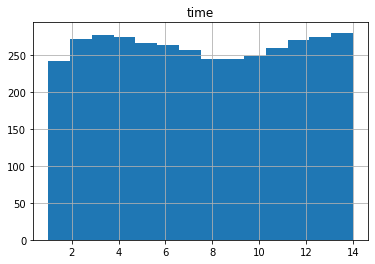

In [10]:
companies.hist(column=['time'], bins=14)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F5ECE96198>]],
      dtype=object)

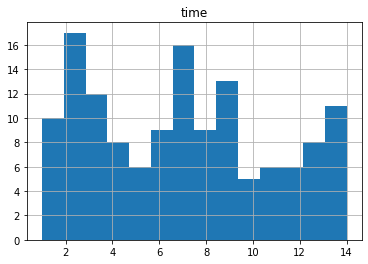

In [11]:
distress_companies.hist(column=['time'], bins=14)

In [6]:

datadict = {}
distress_dict = {}

for i in range (1, total_n+1):
    datadict[i] = {}
    distress_dict[i] = {}

print("Populating dictionary...")
for idx, row in companies.iterrows():
    company = row['company']
    time = int(row['time'])
    
    datadict[company][time] = {}
    
    if row['financial_distress'] < -0.5:
        distress_dict[company][time] = 1
    else:
        distress_dict[company][time] = 0
        
    for feat_idx, column in enumerate(row[3:]):
        feat = feature_names[feat_idx]
        datadict[company][time][feat] = column
        
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(max(f80)))
f80_oh = label_binarizer.transform(f80)

Populating dictionary...


In [8]:
def rolling_operation(time, train_array, datadict, distress_dict, feature_names, total_n,
                         lookback_periods):

    for company in range(1, total_n+1):
            
            all_periods_exist = True
            for j in range(0, lookback_periods):
                if not time-j in distress_dict[company]:
                    all_periods_exist = False
            if not all_periods_exist:
                continue
            
            distress_at_eop = distress_dict[company][time]
            new_row = [company]

            for feature in feature_names:
                if feature == 'x80':
                    continue
                feat_sum = 0.0
                variance_arr = []
                for j in range(0, lookback_periods):
                    feat_sum += datadict[company][time-j][feature]
                    variance_arr.append(datadict[company][time-j][feature])
                new_row.append(feat_sum)
                new_row.append(np.var(variance_arr))
                
            for j in range(0,len(f80_oh[0])):
                new_row.append(f80_oh[company-1][j])

            if len(new_row) == ((len(feature_names)-1)*2 + 1 + len(f80_oh[0])) : # we have a complete row
                new_row.append(distress_at_eop)
                new_row_np = np.asarray(new_row)
                train_array.append(new_row_np)
    

def custom_timeseries_cv(datadict, distress_dict, feature_names, total_n, val_time, test_time, 
                         lookback_periods, total_periods=14):

    # Train data
    train_array = []
    for _t in range(1, val_time+1):
        time = (val_time+1) -_t # Start from time period 10 and work backwards
        train_array_np = rolling_operation(time, train_array, datadict, distress_dict, feature_names, total_n,
                         lookback_periods)

    train_array_np = np.asarray(train_array)
    print(train_array_np.shape)
    # print(train_array_np[0])
    
    # Val data
    if val_time != test_time:
        val_array = []
        for time in range(val_time+1, test_time+1):
            val_array_np = rolling_operation(time, val_array, datadict, distress_dict, feature_names, total_n,
                         lookback_periods)

        val_array_np = np.asarray(val_array)
        print(val_array_np.shape)
        # print(val_array_np[0])
    else:
        val_array_np = None

    # Test data
    test_array = []
    # start from time period 11 and work forwards
    for time in range(test_time+1,total_periods+1):
        test_array_np = rolling_operation(time, test_array, datadict, distress_dict, feature_names, total_n,
                         lookback_periods)

    test_array_np = np.asarray(test_array)
    print(test_array_np.shape)
    # print(test_array_np[0])
    
    return train_array_np, val_array_np, test_array_np

# Generate our sets
train_array_np, val_array_np, test_array_np = custom_timeseries_cv(datadict, distress_dict, feature_names, total_n,
                                                     val_time=9, test_time=12, lookback_periods=3, total_periods=14)

(1678, 203)
(687, 203)
(499, 203)


In [9]:
X_train = train_array_np[:,0:train_array_np.shape[1]-1]
y_train = train_array_np[:,-1].astype(int)

X_val = val_array_np[:,0:val_array_np.shape[1]-1]
y_val = val_array_np[:,-1].astype(int)

X_test = test_array_np[:,0:test_array_np.shape[1]-1]
y_test = test_array_np[:,-1].astype(int)

np.set_printoptions(threshold=sys.maxsize)

In [19]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def model_trial(model_type, hyperparam):
    if model_type in ['logistic-regression']:
        # Logistic Regression. Try 11, l2 penalty, understand one-vs-rest vs multinomial (cross-entropy) 
        model = LogisticRegression(penalty=hyperparam, solver='saga', max_iter=4000)
    elif model_type in ['decision-tree']:
        model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None)
    elif model_type in ['random-forest']:
        model = RandomForestClassifier(n_estimators=hyperparam)
    else:
        print("Warning: model {} not recognized.".format(model_type))
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    f1 = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    print("Mean acc: %f" % model.score(X_val, y_val))
    print("F1: %f" % f1)
    print("Recall: %f" % recall)

In [20]:
print("-"*20 + "Logistic regression, l1:" + "-"*20)
model_trial('logistic-regression', 'l1')

print("-"*20 + "Logistic regression, l2:" + "-"*20)
model_trial('logistic-regression', 'l2')

print("-"*20 + "Decision tree:" + "-"*20)
model_trial('decision-tree', None)

for i in [2, 4, 10, 50, 100, 1000]:
    print("-"*20 + "Random forest, {} estimators:".format(i) + "-"*20)
    model_trial('random-forest', i)

--------------------Logistic regression, l1:--------------------


C:\Users\darya\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Mean acc: 0.976710
F1: 0.000000
Recall: 0.000000
--------------------Logistic regression, l2:--------------------


C:\Users\darya\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Mean acc: 0.976710
F1: 0.000000
Recall: 0.000000
--------------------Decision tree:--------------------
Mean acc: 0.930131
F1: 0.200000
Recall: 0.375000
--------------------Random forest, 2 estimators:--------------------
Mean acc: 0.969432
F1: 0.322581
Recall: 0.312500
--------------------Random forest, 4 estimators:--------------------
Mean acc: 0.970888
F1: 0.090909
Recall: 0.062500
--------------------Random forest, 10 estimators:--------------------
Mean acc: 0.972344
F1: 0.173913
Recall: 0.125000
--------------------Random forest, 50 estimators:--------------------
Mean acc: 0.978166
F1: 0.210526
Recall: 0.125000
--------------------Random forest, 100 estimators:--------------------
Mean acc: 0.979622
F1: 0.300000
Recall: 0.187500
--------------------Random forest, 1000 estimators:--------------------
Mean acc: 0.975255
F1: 0.000000
Recall: 0.000000


In [10]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=15)
clf = knn.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_knb_model=roc_auc_score(y_test, y_pred)*100
acc_knb_model

50.0

In [12]:
lr = LogisticRegression(C = 0.2)
clf1 = lr.fit(X_train, y_train)
y_pred1 = clf1.predict(X_test)
acc_log_reg=roc_auc_score(y_test, y_pred1)*100
acc_log_reg

C:\Users\darya\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


50.0

In [13]:
clf2 = GaussianNB().fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)
acc_nb=roc_auc_score(y_test, y_pred2)*100
acc_nb

51.95175438596491

In [14]:
clf3 = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_pred3 = clf3.predict(X_test)
acc_dt=roc_auc_score(y_test, y_pred3)*100
acc_dt

68.86513157894737

In [15]:
clf4 = RandomForestClassifier(max_depth=5, random_state=0).fit(X_train, y_train)
y_pred4 = clf4.predict(X_test)
acc_rmf_model=roc_auc_score(y_test, y_pred4)*100
acc_rmf_model

49.6875

In [16]:
clf5 = SVC(gamma='auto').fit(X_train, y_train)
y_pred5 = clf5.predict(X_test)
acc_svm_model=roc_auc_score(y_test, y_pred5)*100
acc_svm_model

50.0

In [17]:
sgd_model=SGDClassifier()
sgd_model.fit(X_train,y_train)
sgd_pred=sgd_model.predict(X_test)
acc_sgd=round(sgd_model.score(X_train,y_train)*100,10)
acc_sgd

95.5303933254

In [18]:
xgb_model=XGBClassifier()
xgb_model.fit(X_train,y_train)
xgb_pred=xgb_model.predict(X_test)
acc_xgb=round(xgb_model.score(X_train,y_train)*100,10)
acc_xgb

100.0

In [19]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)
lgbm_pred=lgbm.predict(X_test)
acc_lgbm=round(lgbm.score(X_train,y_train)*100,10)
acc_lgbm

100.0

In [20]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
regr_pred=regr.predict(X_test)
acc_regr=round(regr.score(X_train,y_train)*100,10)
acc_regr

27.4436529893

In [21]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest','Stochastic Gradient Decent','Linear Regression','Naive Bayes','XGBoost','LightGBM','Decision Tree'],
    'Score': [acc_svm_model, acc_knb_model, acc_log_reg, 
              acc_rmf_model,acc_sgd,acc_regr,acc_nb,acc_xgb,acc_lgbm,acc_dt]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model
Score,
100.000000,XGBoost
100.000000,LightGBM
95.530393,Stochastic Gradient Decent
68.865132,Decision Tree
51.951754,Naive Bayes
50.000000,Support Vector Machines
50.000000,KNN
50.000000,Logistic Regression
49.687500,Random Forest
